In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
recent_date

'2017-08-23'

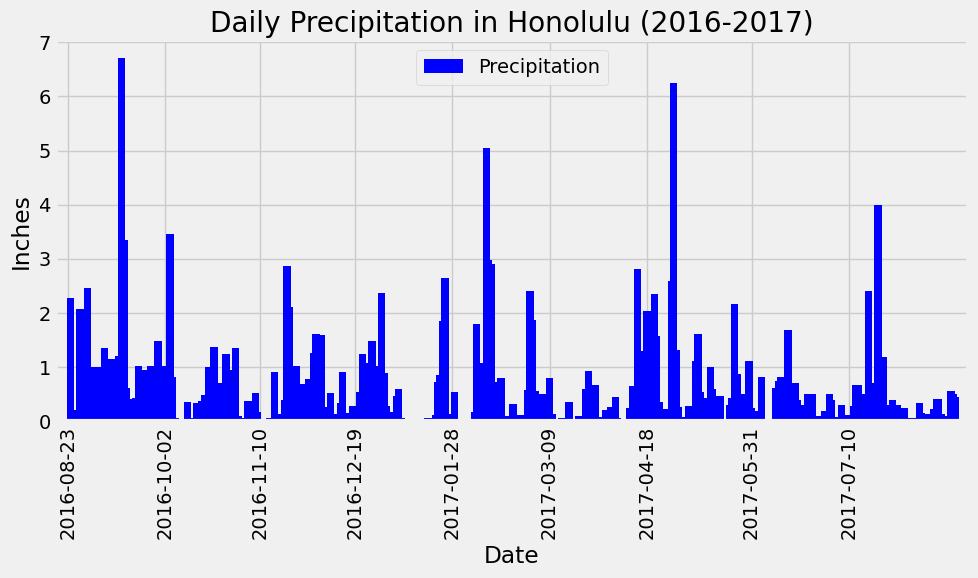

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()
    

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

# Check if the 'one_year_ago' date is in the DataFrame
if one_year_ago not in precipitation_df['date'].values:
    # If not, add a row with the 'one_year_ago' date
    new_row = pd.DataFrame({'date': [one_year_ago], 'precipitation': [0]})
    precipitation_df = pd.concat([precipitation_df, new_row])

precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['date'], precipitation_df['precipitation'], color='blue', width=3)
# Find adequate spacing of dates in the x axis to match exactly as the image example
plt.xticks(precipitation_df['date'][::249], precipitation_df['date'].dt.strftime('%Y-%m-%d')[::249], rotation=90)


plt.title('Daily Precipitation in Honolulu (2016-2017)')
plt.xlabel('Date')
plt.ylabel('Inches') 
plt.legend(['Precipitation'], loc='upper center')

# Adjust x-axis limits to reduce space
plt.xlim(precipitation_df['date'].min() - pd.Timedelta(days=5), 
         precipitation_df['date'].max() + pd.Timedelta(days=5))

plt.tight_layout()
plt.show()

In [42]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['precipitation'].describe()
print(precipitation_summary)

count    2016.000000
mean        0.176374
std         0.460191
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [43]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [44]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs), 
                                  func.max(Measurement.tobs), 
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).all()

temperature_stats


[(54.0, 85.0, 71.66378066378067)]

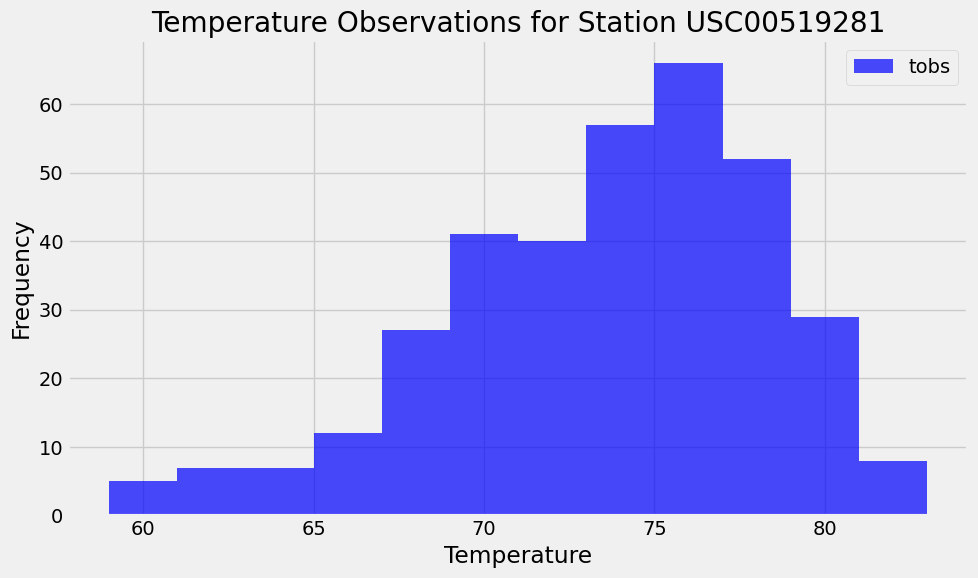

In [46]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

plt.figure(figsize=(10, 6))
plt.hist(temperature_df['tobs'], bins=12, color='blue', alpha=0.7)
plt.title('Temperature Observations for Station ' + most_active_station_id)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'], loc='best') # tobs = temperature observations

plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()